## select GPU

In [1]:
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 2, 3"


SEED = 69

os.environ["WANDB_NOTEBOOK_NAME"] = "training_student.ipynb"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load the distilled dataset from disk

In [2]:
import pandas as pd

df = pd.read_csv('sample/merged_distilled_dataset.csv')

In [3]:
from datasets import Dataset

distilled_dataset = Dataset.from_pandas(df)
distilled_dataset

Dataset({
    features: ['prompt', 'response'],
    num_rows: 30000
})

## Load student model

In [4]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import AutoTokenizer, AutoModelForCausalLM

STUDENT_MODEL = 'EleutherAI/gpt-neo-1.3B'

student_tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL, trust_remote_code=True)
student_tokenizer.pad_token = student_tokenizer.eos_token

student_model = AutoModelForCausalLM.from_pretrained(STUDENT_MODEL, torch_dtype=torch.float16, device_map="auto")

student_model = prepare_model_for_kbit_training(student_model)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=['q_proj', 'v_proj'],
    lora_dropout=0.1,
    bias='none',
    task_type='CAUSAL_LM'
)
student_model = get_peft_model(student_model, lora_config)

### Tokenize Distilled Dataset

In [5]:
MAX_TOKENS = 128

def tokenize_fn(example):
    prompt = example.get('prompt') or ''
    response = example.get('response') or ''
    full_text = prompt + ' ' + response
    return student_tokenizer(full_text, truncation=True, padding='max_length', max_length=MAX_TOKENS)

# tokenized_dataset = distilled_dataset.map(tokenize_fn)
tokenized_dataset = distilled_dataset.map(tokenize_fn)
tokenized_dataset = tokenized_dataset.map(lambda x: {"labels": x["input_ids"]})

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [6]:
#tokenized_dataset[69]

In [7]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.3, seed=SEED)
val_test_split = split_dataset['test'].train_test_split(test_size=0.5, seed=SEED)
train_dataset = split_dataset['train']
valid_dataset = val_test_split['train']
test_dataset = val_test_split['test']

In [8]:
len(train_dataset)

21000

In [9]:
len(valid_dataset)

4500

## Training Arguments & Trainer

In [10]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir=f"models/{STUDENT_MODEL}lora-distilled",
    run_name=f'{STUDENT_MODEL}-lora-distilled',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    # num_train_epochs=1,
    learning_rate=2e-4,
    fp16=True,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    save_strategy="steps",
    eval_strategy="steps",
    eval_steps=100,
    # eval_strategy="no",
    save_safetensors=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)


trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


[2025-04-23 14:44:28,846] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/tljh/user/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/tljh/user/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## Start Training

In [11]:
train_result = trainer.train()
save_path = f"models/{STUDENT_MODEL}-{MAX_TOKENS}"
trainer.save_model(save_path)
student_tokenizer.save_pretrained(save_path)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find training_student.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: st124974 (binit-ait) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
100,1.670000,1.399044
200,1.352000,1.318267
300,1.280900,1.280165
400,1.256800,1.258327
500,1.239900,1.244281
600,1.225100,1.234746
700,1.219500,1.227795
800,1.212000,1.223341
900,1.199400,1.220488


Could not locate the best model at models/EleutherAI/gpt-neo-1.3Blora-distilled/checkpoint-900/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


('models/EleutherAI/gpt-neo-1.3B-128/tokenizer_config.json',
 'models/EleutherAI/gpt-neo-1.3B-128/special_tokens_map.json',
 'models/EleutherAI/gpt-neo-1.3B-128/vocab.json',
 'models/EleutherAI/gpt-neo-1.3B-128/merges.txt',
 'models/EleutherAI/gpt-neo-1.3B-128/added_tokens.json',
 'models/EleutherAI/gpt-neo-1.3B-128/tokenizer.json')

In [12]:
test_results = trainer.evaluate(test_dataset)

In [13]:
import json
print(json.dumps(test_results, indent=4))

{
    "eval_loss": 1.2192639112472534,
    "eval_runtime": 110.3351,
    "eval_samples_per_second": 40.785,
    "eval_steps_per_second": 10.196,
    "epoch": 2.9935238095238095
}


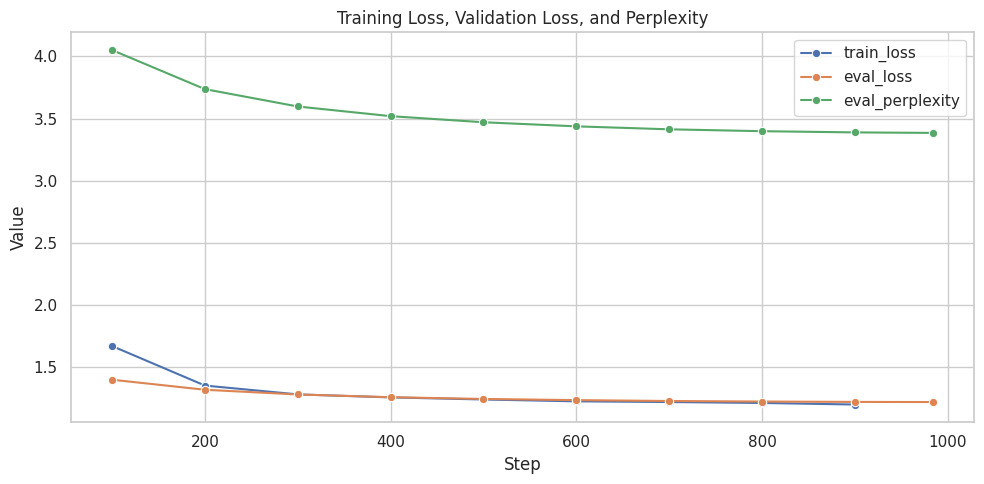

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

log_history = trainer.state.log_history
train_steps = [entry["step"] for entry in log_history if "loss" in entry]
eval_steps = [entry["step"] for entry in log_history if "eval_loss" in entry]
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
eval_ppl = [torch.exp(torch.tensor(loss)).item() for loss in eval_loss]

plot_data = pd.DataFrame({
    "step": train_steps + eval_steps * 2,
    "value": train_loss + eval_loss + eval_ppl,
    "type": ["train_loss"] * len(train_steps) + ["eval_loss"] * len(eval_steps) + ["eval_perplexity"] * len(eval_steps)
})

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(data=plot_data, x="step", y="value", hue="type", marker="o")
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Training Loss, Validation Loss, and Perplexity")
plt.legend()
plt.tight_layout()
plt.savefig(f"models/{STUDENT_MODEL}_{MAX_TOKENS}.png")

